In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import warnings
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

warnings.filterwarnings('ignore')

2.6.4


# Load Data

In [11]:
seed = 42

In [2]:
data_dir = '/kaggle/input/preprocessed-datatset'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [3]:
labels = ['N','P','T']

img_h = 256
img_w = 256

input_shape = (256, 256, 3)
classes = 3

In [5]:
datagen = ImageDataGenerator()

test_set = datagen.flow_from_directory(
        directory = test_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        target_size = (img_h, img_w),
        batch_size = 32,
        shuffle = False
    )

Found 2309 images belonging to 3 classes.


In [14]:
y_test = test_set.labels

# Load Model

In [6]:
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [7]:
model = tfk.models.load_model('/kaggle/input/model-final', custom_objects={'f1':f1})

2023-02-06 02:32:52.132103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:32:52.133019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:32:52.252568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:32:52.253366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:32:52.254086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 256, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_1[0][0]            
______________________________________________________________________________________________

# t-SNE

## GAP

In [9]:
latent = tf.keras.Model(model.input, model.get_layer('gap').output)
latent_rep = latent.predict(test_set)
latent_rep.shape

2023-02-06 02:33:34.523156: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 02:33:37.607286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(2309, 1408)

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=seed)
z = tsne.fit_transform(latent_rep)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2309 samples in 0.004s...
[t-SNE] Computed neighbors for 2309 samples in 0.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2309
[t-SNE] Computed conditional probabilities for sample 2000 / 2309
[t-SNE] Computed conditional probabilities for sample 2309 / 2309
[t-SNE] Mean sigma: 1.829740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.217674
[t-SNE] KL divergence after 1000 iterations: 0.915093


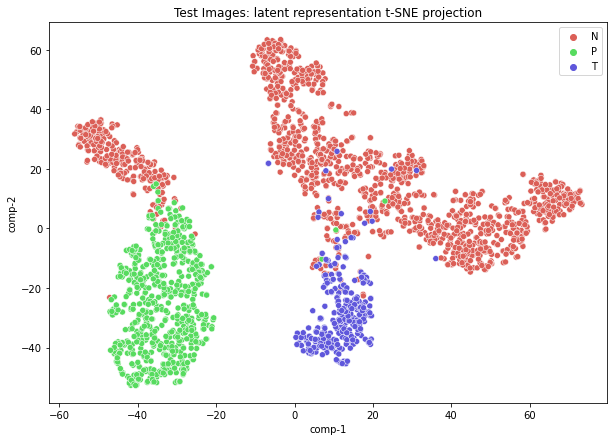

In [17]:
df = pd.DataFrame()
df["y"] = [labels[i] for i in y_test]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

plt.figure(figsize = (10,7))
A = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Test Images: latent representation t-SNE projection");

## Laste dense

In [18]:
latent = tf.keras.Model(model.input, model.get_layer('dense_7').output)
latent_rep = latent.predict(test_set)

tsne = TSNE(n_components=2, verbose=1, random_state=seed)
z = tsne.fit_transform(latent_rep)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2309 samples in 0.001s...
[t-SNE] Computed neighbors for 2309 samples in 0.175s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2309
[t-SNE] Computed conditional probabilities for sample 2000 / 2309
[t-SNE] Computed conditional probabilities for sample 2309 / 2309
[t-SNE] Mean sigma: 6.735312
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.772278
[t-SNE] KL divergence after 1000 iterations: 0.528964


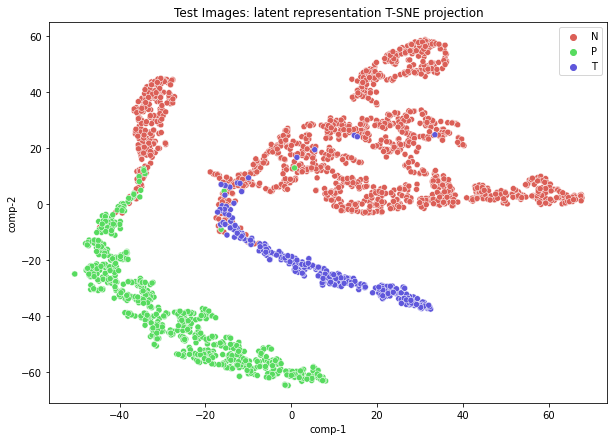

In [19]:
df = pd.DataFrame()
df["y"] = [labels[i] for i in y_test]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

plt.figure(figsize = (10,7))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Test Images: latent representation T-SNE projection");

# Fairness

In [22]:
test_predictions = model.predict(test_set)

## top 2 difference

Text(0, 0.5, 'Log Frequency')

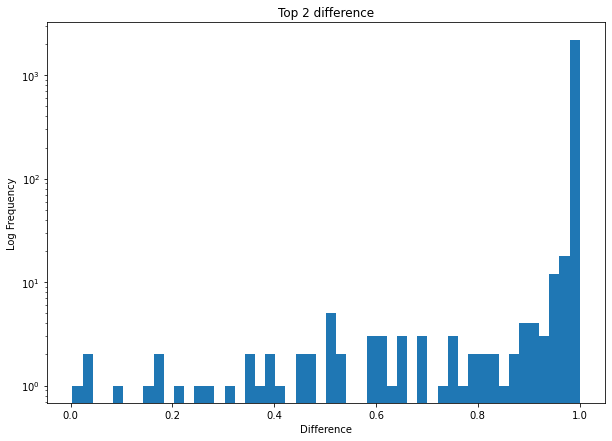

In [23]:
sorted_predictions = np.sort(test_predictions, axis=1)
diff = sorted_predictions[:,2] - sorted_predictions[:,1]

plt.figure(figsize=(10,7))
plt.hist(diff, bins=50, log=True);
plt.title('Top 2 difference')
plt.xlabel('Difference')
plt.ylabel('Log Frequency')


## US

Text(0, 0.5, 'Log Frequency')

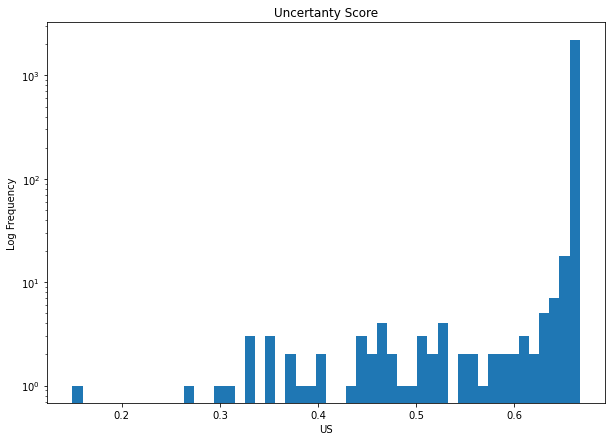

In [24]:
US = 1 - 1/(3*np.sum(np.square(test_predictions), axis=1))


plt.figure(figsize=(10,7))
plt.hist(US, bins=50, log=True);
plt.title('Uncertanty Score')
plt.xlabel('US')
plt.ylabel('Log Frequency')
